In [1]:
import numpy as np
import pandas as pd
import gdal
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import plot_confusion_matrix

from sklearn.preprocessing import StandardScaler,MinMaxScaler

from rasterio import plot

import seaborn as sn
import pandas as pd


# Μέρος Α

In [2]:
green_tif = gdal.Open("./GBDA2020_ML1/partA/green.tif")
green_data = green_tif.ReadAsArray().flatten()

nir_tif = gdal.Open("./GBDA2020_ML1/partA/nir.tif")
nir_data = nir_tif.ReadAsArray().flatten()

labels_tif = gdal.Open("./GBDA2020_ML1/partA/gt.tif")
labels_data = labels_tif.ReadAsArray().flatten()
labels_data = np.where(labels_data==255,1,labels_data)

data = np.concatenate((np.expand_dims(green_data,axis=1),np.expand_dims(nir_data,axis=1)),axis=1)


In [3]:
# AM: 03400121
# train-test set, 70-30 %
X_train, X_test, y_train, y_test =  train_test_split(data, labels_data, test_size=0.3, random_state=121)

Αρχικοποιώ τα μοντέλα του πρώτου ερωτήματος, τα εκπαιδεύω και εμφανίζω τις απαιτούμενες μετρικές αξιολόγησης.

Gaussian Naive Bayes
Accuracy : 0.9980966666666666
Precision : 0.9997233383835057
Recall : 0.9928042494177983
F1 Score : 0.9962517805683377
True Positives : 75884
True Negatives : 223545
False Positives : 21
False Negatives : 550


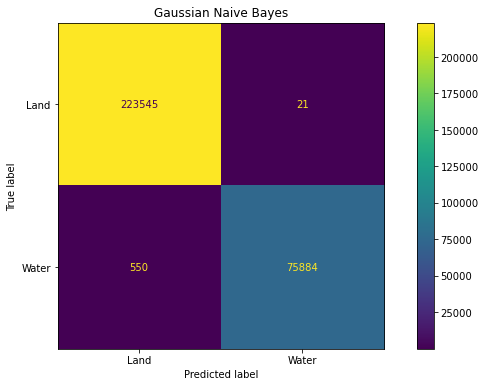

K-Nearest Neighbors
Accuracy : 1.0
Precision : 1.0
Recall : 1.0
F1 Score : 1.0
True Positives : 76434
True Negatives : 223566
False Positives : 0
False Negatives : 0


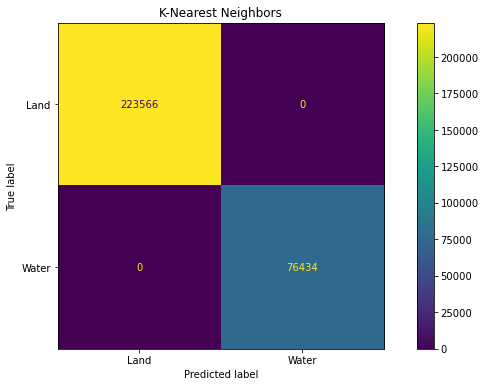

Simple Perceptron
Accuracy : 1.0
Precision : 1.0
Recall : 1.0
F1 Score : 1.0
True Positives : 76434
True Negatives : 223566
False Positives : 0
False Negatives : 0


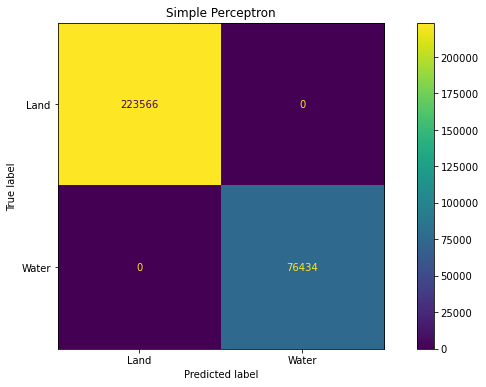

In [4]:
my_clfs = { 
    "Gaussian Naive Bayes" : GaussianNB(),
    "K-Nearest Neighbors" : KNeighborsClassifier(n_neighbors=3,n_jobs=-1),
    "Simple Perceptron" : Perceptron(tol=1e-3, random_state=121,n_jobs=-1)
}
for title, clf in my_clfs.items():
    print(title)
    clf.fit(X_train,y_train)
    
    pred = clf.predict(X_test)
    print("Accuracy :", clf.score(X_test, y_test))
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    prec, rec, f1, sup = precision_recall_fscore_support(y_test, pred,average='binary')
    
    print("Precision :", prec)
    print("Recall :", rec)
    print("F1 Score :", f1)
    
    print("True Positives :", tp)
    print("True Negatives :", tn)
    print("False Positives :",fp)
    print("False Negatives :",fn)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title(title)
    plot_confusion_matrix(clf, X_test, y_test, display_labels=["Land","Water"],ax=ax) 
    plt.show()
    
    
    

Με βάση τα αποτελέσματα που δίνουν οι αλγόριθμοι είναι εμφανές πως τα δεδομένα μας είναι καλώς ορισμένα και μπορούν να διαχωρίσουν τις δυο κλάσεις τέλεια. Τα αποτελέσματα είναι τέλεια με μόνο τον Gaussian classifier να πραγματοποιεί ελάχιστα λάθη. Το πρόβλημα που καλούνται να λύσουν οι αλγόριθμοι είναι σχετικά απλό, ενώ η παρουσία μεγάλου αριθμού δεδομένων για την εκπαίδευση καθιστά δυνατά αυτά τα ποσοστά επιτυχίας.

# Μέρος Β

Φορτώνω και επεξεργάζομαι τα δεδομένα του δεύτερου ερωτήματος. Αφαιρείται η κλάση 0 από τα data και τα labels, και οι κλάσεις για λόγους ευκολίας στη συνέχεια μετατρέπονται από 1-16 σε 0-15.

In [5]:
data_b = np.load("./GBDA2020_ML1/partB/indianpinearray.npy").transpose().reshape((200,-1)).transpose().astype(np.int16)
labels_b = np.load("./GBDA2020_ML1/partB/IPgt.npy").flatten().astype(np.int16)

clean_data = np.delete(data_b,np.where(labels_b==0),0)
clean_labels = np.delete(labels_b,np.where(labels_b==0),0)
clean_labels = clean_labels-1

Για τα μοντέλα που θα ζητούνται να εξεταστούν είναι απαραίτητη η προεπεξέργασία των δεδομένων. Συγκεκριμένα γίνεται κανονικοποίηση των δεδομένων. Δύο επιλογές εξετάστηκαν:

1. Κανονικοποίηση Max-Min δίνονται νέες τιμές στα δεδομένα στο διάστημα [0,1]
2. Κανονικοποίηση χρησιμοποιώντας τη μέση τιμή και τη διασπορά του κάθε χαρακτηριστικού ώστε να ακολουθούν τα δεδομένα την κανονική κατανομή ανά χαρακτηριστικό.

Επιλέχθηκε η δεύτερη προσέγγιση καθώς έδωσε καλύτερα αποτελέσματα.

In [6]:
# scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(clean_data)
scaled_data = scaler.transform(clean_data)

Για τα μοντέλα MLP χρειάστηκε και ένα validation set. Για να είναι δυνατή η σύγκριση μεταξύ όλων των εξεταζόμενων μοντέλων, χρησιμοποιήθηκαν τα ίδια δεδομένα εκπαίδευσης και ελέγχου σε όλες τις περιπτώσεις.

In [7]:
# AM: 03400121
# train-val-test 60-10-30 , 
X_train, X_test, y_train, y_test =  train_test_split(scaled_data, clean_labels, test_size=0.3, random_state=121,stratify=clean_labels)
X_train, X_val, y_train, y_val =  train_test_split(X_train, y_train, test_size=0.143, random_state=121,stratify=y_train) #1/7 of train set or 1/10 of total data

Αρχικοποιώ τα μοντέλα των SVM και RF, τα εκπαιδεύω και εμφανίζω τις απαιτούμενες μετρικές.

Support Vector Machine
Accuracy : 0.6386991869918699
Precision : [0.27777778 0.61571125 0.55597015 0.80519481 0.5112782  0.52763819
 0.5        0.7        0.5        0.6294964  0.68970013 0.53157895
 0.54054054 0.74185464 0.68918919 0.72727273]
Recall : [0.35714286 0.67757009 0.59839357 0.87323944 0.46896552 0.47945205
 0.375      0.63636364 0.5        0.59931507 0.71777476 0.56741573
 0.32786885 0.77894737 0.43965517 0.57142857]
F1 Score : [0.3125     0.64516129 0.57640232 0.83783784 0.48920863 0.50239234
 0.42857143 0.66666667 0.5        0.61403509 0.70345745 0.54891304
 0.40816327 0.75994865 0.53684211 0.64      ]
Precision micro: 0.6386991869918699
Recall micro: 0.6386991869918699
F1 Score micro: 0.6386991869918699


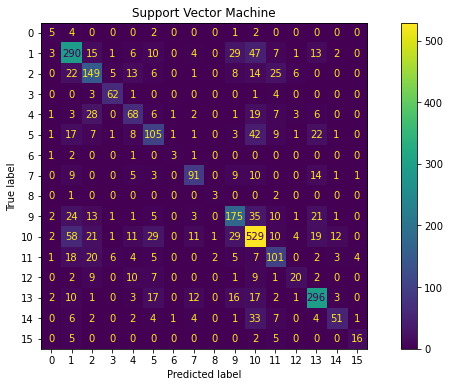

----------------------------------------------------------------------
Random Forest
Accuracy : 0.5886178861788618
Precision : [0.66666667 0.58874459 0.50877193 0.69879518 0.5        0.45833333
 0.         0.70192308 1.         0.71244635 0.60733549 0.61643836
 0.4137931  0.51004016 0.81333333 0.82352941]
Recall : [0.14285714 0.63551402 0.46586345 0.81690141 0.34482759 0.35159817
 0.         0.51048951 0.33333333 0.56849315 0.76390773 0.50561798
 0.19672131 0.66842105 0.52586207 0.5       ]
F1 Score : [0.23529412 0.61123596 0.48637317 0.75324675 0.40816327 0.39793282
 0.         0.59109312 0.5        0.63238095 0.67668269 0.55555556
 0.26666667 0.5785877  0.63874346 0.62222222]
Precision micro: 0.5886178861788618
Recall micro: 0.5886178861788618
F1 Score micro: 0.5886178861788618


/home/christos/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


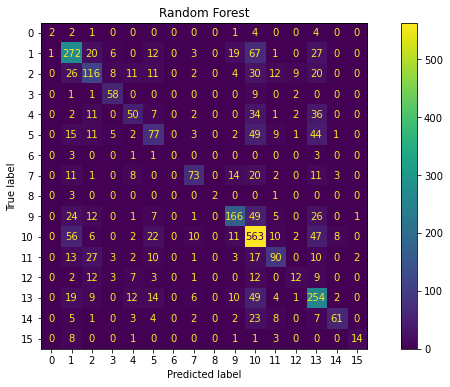

----------------------------------------------------------------------


In [8]:
my_clfs_b = { 
    "Support Vector Machine" : SVC(C=50),
    "Random Forest" : RandomForestClassifier(criterion="entropy",max_features="sqrt",random_state=121,n_jobs=12),
}

for title, clf in my_clfs_b.items():
    print(title)
    clf.fit(X_train,y_train)
    
    pred = clf.predict(X_test)
    print("Accuracy :", clf.score(X_test, y_test))
    prec, rec, f1, sup = precision_recall_fscore_support(y_test, pred)
    
    print("Precision :", prec)
    print("Recall :", rec)
    print("F1 Score :", f1)
    
    prec_micro, rec_micro, f1_micro, sup_micro = precision_recall_fscore_support(y_test, pred,average='micro')
        
    print("Precision micro:", prec_micro)
    print("Recall micro:", rec_micro)
    print("F1 Score micro:", f1_micro)

    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title(title)
    plot_confusion_matrix(clf, X_test, y_test, ax=ax) 
    plt.show()
    
    print("----------------------------------------------------------------------")
#     break



Για τα μονέλα MLP δημιουργήθηκαν δυο απλά δίκτυα. Το πρώτο αποτελείται από ένα shallow network χωρίς κανένα κρυφό επίπεδο, το οποίο προβάλει την είσοδο των 200 χαρακηριστικών στις 16 κατηγορίες εξόδου. Ως δευτερη αρχιτεκτονική για τα MLP δημιουργήθηκε ένα δίκτυο με 3 κρυφά επίπεδα με 100,50,25 νευρώνες αντίστοιχα. Στο δεύτερο δίκτυο παρατηρήθηκε overfitting γι αυτό χρησιμοποιήθηκε η τεχνική του dropout για να μειωθεί η επίδρασή του. Προς το τέλος του notebook υπάρχουν διαγράμματα για την εκπαίδευση των μοντέλων όπου γίνεται εμφανές το overfitting.

In [21]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader

    
class my_MLP_V1(nn.Module):
    def __init__(self):
        super().__init__()
        
#         self.fc1 = nn.Linear(200,50)
#         self.fc2 = nn.Linear(50,25)
        self.fc3 = nn.Linear(200,16)

        
        
    def forward(self,x):
        
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x),dim=1)
    
        return x

    
class my_MLP_V2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(200,100)
        self.fc2 = nn.Linear(100,50)
        self.fc3 = nn.Linear(50,25)
        self.fc4 = nn.Linear(25,16)
    
        self.dropout = nn.Dropout(p=0.2)
        
        
    def forward(self,x):
        
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x),dim=1)
    
        return x


# transform to torch tensors
tensor_x_train = torch.from_numpy(X_train).type(torch.FloatTensor) 
tensor_y_train = torch.from_numpy(y_train).type(torch.LongTensor)

tensor_x_val = torch.from_numpy(X_val).type(torch.FloatTensor) 
tensor_y_val = torch.from_numpy(y_val).type(torch.LongTensor)

tensor_x_test = torch.from_numpy(X_test).type(torch.FloatTensor) 
tensor_y_test = torch.from_numpy(y_test).type(torch.LongTensor)


# create train, validation, test datsets and create dataloaders
my_dataset_train = TensorDataset(tensor_x_train,tensor_y_train) 
my_dataloader_train = DataLoader(my_dataset_train,batch_size=64, shuffle=True) 

my_dataset_val = TensorDataset(tensor_x_val,tensor_y_val) 
my_dataloader_val = DataLoader(my_dataset_val,batch_size=64, shuffle=True)

my_dataset_test = TensorDataset(tensor_x_test,tensor_y_test) 
my_dataloader_test = DataLoader(my_dataset_test,batch_size=64, shuffle=True)

In [18]:
# mlp train function
def MLP_train_model(model,epochs=300):
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.NLLLoss()
    
    train_losses, val_losses = [], []
    for e in range(epochs):
        tot_train_loss = 0
        for images, labels in my_dataloader_train:
            optimizer.zero_grad()
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            

            loss.backward()
            optimizer.step()
            tot_train_loss += loss.item()
        else:
            tot_val_loss = 0
            # Number of correct predictions on the validation set
            val_correct = 0  

            # Turn off gradients for validation and put model on evaluation mode
            with torch.no_grad():
                model.eval()
                for images, labels in my_dataloader_val:
                    log_ps = model(images)
                    loss = criterion(log_ps, labels)
                    tot_val_loss += loss.item()

                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    val_correct += equals.sum().item()
                    
            # Put model on training mode again
            model.train()

            # Get mean loss to enable comparison between train and test sets
            train_loss = tot_train_loss / len(my_dataloader_train.dataset)
            val_loss = tot_val_loss / len(my_dataloader_val.dataset)

            # At completion of epoch
            train_losses.append(train_loss)
            val_losses.append(val_loss)

            if (e)%10==9 or e==0:
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(train_loss),
                      "Validation Loss: {:.3f}.. ".format(val_loss),
                      "Validation Accuracy: {:.3f}".format(val_correct / len(my_dataloader_val.dataset)))

    
    plt.figure(figsize=(14,7))
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.legend(frameon=False)
    
    return


Epoch: 1/300..  Training Loss: 0.040..  Validation Loss: 0.041..  Validation Accuracy: 0.229
Epoch: 10/300..  Training Loss: 0.030..  Validation Loss: 0.033..  Validation Accuracy: 0.349
Epoch: 20/300..  Training Loss: 0.027..  Validation Loss: 0.031..  Validation Accuracy: 0.405
Epoch: 30/300..  Training Loss: 0.026..  Validation Loss: 0.030..  Validation Accuracy: 0.395
Epoch: 40/300..  Training Loss: 0.025..  Validation Loss: 0.027..  Validation Accuracy: 0.434
Epoch: 50/300..  Training Loss: 0.025..  Validation Loss: 0.026..  Validation Accuracy: 0.426
Epoch: 60/300..  Training Loss: 0.024..  Validation Loss: 0.026..  Validation Accuracy: 0.439
Epoch: 70/300..  Training Loss: 0.024..  Validation Loss: 0.026..  Validation Accuracy: 0.446
Epoch: 80/300..  Training Loss: 0.024..  Validation Loss: 0.026..  Validation Accuracy: 0.446
Epoch: 90/300..  Training Loss: 0.023..  Validation Loss: 0.027..  Validation Accuracy: 0.446
Epoch: 100/300..  Training Loss: 0.023..  Validation Loss: 0.

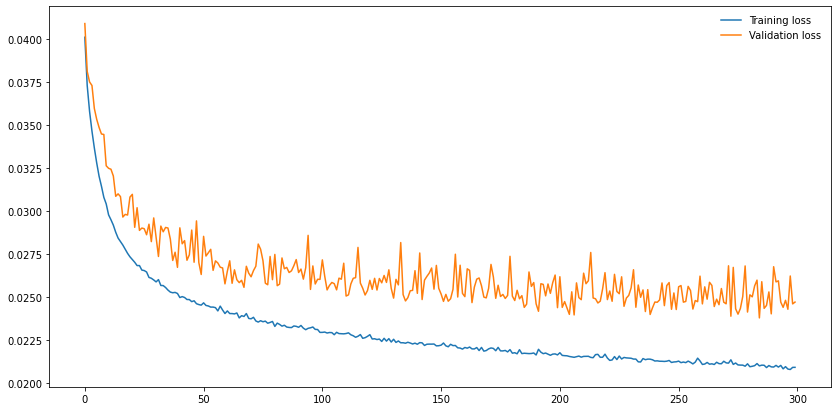

In [19]:
model1 = my_MLP_V1()
MLP_train_model(model1)

Epoch: 1/300..  Training Loss: 0.036..  Validation Loss: 0.036..  Validation Accuracy: 0.279
Epoch: 10/300..  Training Loss: 0.023..  Validation Loss: 0.027..  Validation Accuracy: 0.449
Epoch: 20/300..  Training Loss: 0.019..  Validation Loss: 0.023..  Validation Accuracy: 0.527
Epoch: 30/300..  Training Loss: 0.017..  Validation Loss: 0.021..  Validation Accuracy: 0.555
Epoch: 40/300..  Training Loss: 0.015..  Validation Loss: 0.022..  Validation Accuracy: 0.574
Epoch: 50/300..  Training Loss: 0.014..  Validation Loss: 0.019..  Validation Accuracy: 0.566
Epoch: 60/300..  Training Loss: 0.013..  Validation Loss: 0.019..  Validation Accuracy: 0.585
Epoch: 70/300..  Training Loss: 0.011..  Validation Loss: 0.020..  Validation Accuracy: 0.573
Epoch: 80/300..  Training Loss: 0.010..  Validation Loss: 0.020..  Validation Accuracy: 0.605
Epoch: 90/300..  Training Loss: 0.010..  Validation Loss: 0.020..  Validation Accuracy: 0.598
Epoch: 100/300..  Training Loss: 0.009..  Validation Loss: 0.

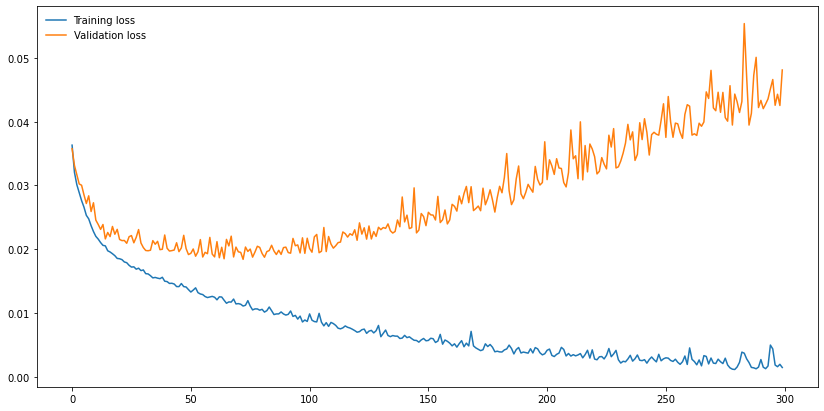

In [22]:
# without dropout layers we get overfitting
model2 = my_MLP_V2()
MLP_train_model(model2)

Epoch: 1/300..  Training Loss: 0.038..  Validation Loss: 0.035..  Validation Accuracy: 0.283
Epoch: 10/300..  Training Loss: 0.027..  Validation Loss: 0.027..  Validation Accuracy: 0.444
Epoch: 20/300..  Training Loss: 0.023..  Validation Loss: 0.024..  Validation Accuracy: 0.504
Epoch: 30/300..  Training Loss: 0.022..  Validation Loss: 0.021..  Validation Accuracy: 0.514
Epoch: 40/300..  Training Loss: 0.021..  Validation Loss: 0.020..  Validation Accuracy: 0.545
Epoch: 50/300..  Training Loss: 0.020..  Validation Loss: 0.022..  Validation Accuracy: 0.543
Epoch: 60/300..  Training Loss: 0.020..  Validation Loss: 0.020..  Validation Accuracy: 0.580
Epoch: 70/300..  Training Loss: 0.019..  Validation Loss: 0.021..  Validation Accuracy: 0.578
Epoch: 80/300..  Training Loss: 0.018..  Validation Loss: 0.018..  Validation Accuracy: 0.575
Epoch: 90/300..  Training Loss: 0.018..  Validation Loss: 0.019..  Validation Accuracy: 0.583
Epoch: 100/300..  Training Loss: 0.018..  Validation Loss: 0.

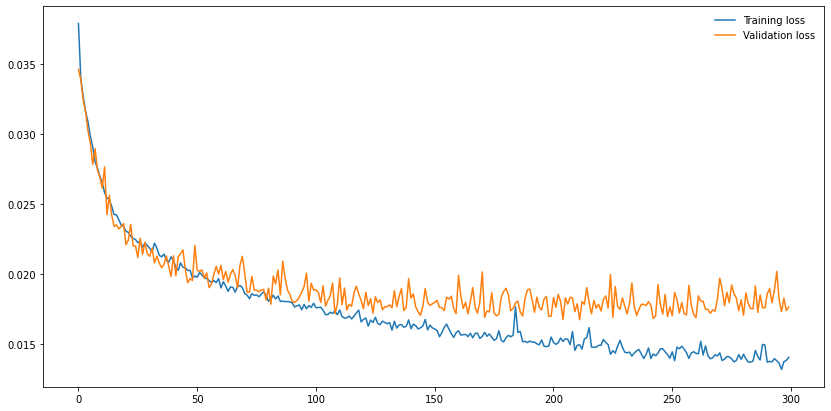

In [20]:
# with dropout to counter overfitting
model2 = my_MLP_V2()
MLP_train_model(model2)

In [30]:
# mlp test function and resutls
def MLP_test_results(model):
    tot_test_loss = 0
    test_correct = 0  
    all_predictions = []
    all_labels = []
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.NLLLoss()
    
    with torch.no_grad():
        model.eval()
        for images, labels in my_dataloader_test:
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            tot_test_loss += loss.item()

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            all_predictions.append(list(top_class.numpy().squeeze()))
            all_labels.append(list(labels.numpy().squeeze()))
            equals = top_class == labels.view(*top_class.shape)
            test_correct += equals.sum().item()

            test_loss = tot_test_loss / len(my_dataloader_test.dataset)

    print("Test Loss: {:.3f}.. ".format(test_loss),"Test Accuracy: {:.3f}".format(test_correct / len(my_dataloader_test.dataset)))

    pred_list = [item for sublist in all_predictions for item in sublist]
    labels_list = [item for sublist in all_labels for item in sublist]
    
    prec, rec, f1, sup = precision_recall_fscore_support(labels_list, pred_list)
    
    print("Precision :", prec)
    print("Recall :", rec)
    print("F1 Score :", f1)
    
    
    
    prec_micro, rec_micro, f1_micro, sup_micro = precision_recall_fscore_support(labels_list, pred_list,average='micro')
        
    print("Precision micro:", prec_micro)
    print("Recall micro:", rec_micro)
    print("F1 Score micro:", f1_micro)
    
    cm=confusion_matrix(labels_list,pred_list)

    df_cm = pd.DataFrame(cm, index = range(1,17),
                      columns = range(1,17))
    plt.figure(figsize = (10,8)) 
    sn.heatmap(df_cm, annot=True,fmt='d')
    t = plt.yticks(rotation=0)
    
    return

Test Loss: 0.023..  Test Accuracy: 0.498
Precision : [1.         0.46131805 0.45454545 0.625      0.41353383 0.34782609
 0.66666667 0.54716981 0.2        0.46258503 0.51896208 0.39072848
 0.35       0.59396752 0.61538462 0.69230769]
Recall : [0.07142857 0.37616822 0.46184739 0.77464789 0.37931034 0.25570776
 0.25       0.40559441 0.16666667 0.46575342 0.70556309 0.33146067
 0.1147541  0.67368421 0.34482759 0.32142857]
F1 Score : [0.13333333 0.41441441 0.45816733 0.6918239  0.39568345 0.29473684
 0.36363636 0.46586345 0.18181818 0.46416382 0.59804485 0.35866261
 0.17283951 0.63131936 0.44198895 0.43902439]
Precision micro: 0.4978861788617886
Recall micro: 0.4978861788617886
F1 Score micro: 0.4978861788617886


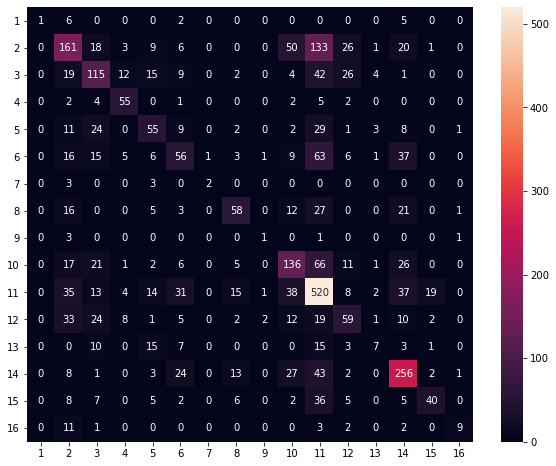

In [31]:
MLP_test_results(model1)

Test Loss: 0.038..  Test Accuracy: 0.631
Precision : [0.33333333 0.64332604 0.546875   0.78666667 0.56557377 0.50490196
 0.33333333 0.57228916 0.5        0.63773585 0.69559413 0.56424581
 0.33870968 0.75193798 0.52777778 0.51851852]
Recall : [0.21428571 0.68691589 0.562249   0.83098592 0.47586207 0.47031963
 0.125      0.66433566 0.5        0.57876712 0.70691995 0.56741573
 0.3442623  0.76578947 0.49137931 0.5       ]
F1 Score : [0.26086957 0.66440678 0.55445545 0.80821918 0.51685393 0.48699764
 0.18181818 0.61488673 0.5        0.60682226 0.70121131 0.56582633
 0.34146341 0.75880052 0.50892857 0.50909091]
Precision micro: 0.631219512195122
Recall micro: 0.631219512195122
F1 Score micro: 0.631219512195122


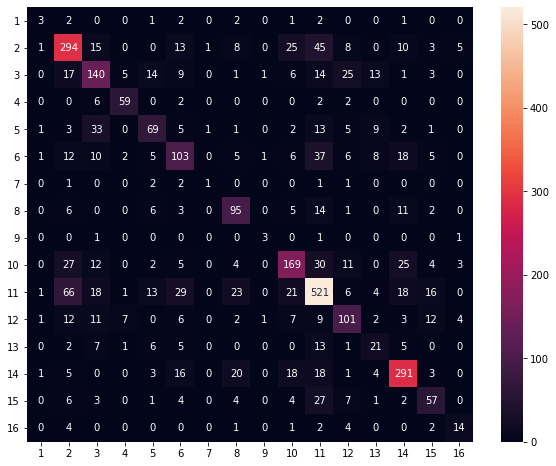

In [32]:
MLP_test_results(model2)

## Σχολιασμός αποτελεσμάτων

### Β1
Παρατηρούμε πως όλοι οι αλγόριθμοι δίνουν σχετικά κοντινά αποτελέσματα γύρω από το 60% εκτός του πρώτου mlp που κινείται κάτω από το 50%. Συγκεκριμένα τα αποτελέσματά του accuracy τους είναι:
- SVM: 63.8%
- RF: 58.8%
- MLP v1: 48.5%
- MLP v2: 63.0%

Για τα απλα μοντέλα που εξετάζουμε και τα imbalanced δεδομένα που έχουμε στη διάθεση μας το ποσοστό επιτυχίας είναι αποδεκτό. Αν οι αλγοριθμοι αποτύγχαναν τελείως θα έδιναν τυχαίες προβλέψεις για κάθε κλαση με ποσοστό επιτυχίας περίπου 1/16=6.25%, ενώ εμείς λαμβάνουμε ποσοστό επιτυχίας 10 φορές μεγαλύτερο που σημαίνει πως τα μοντέλα μας καταφέρνουν ως ενα βαθμό να διαχωρίσουν τις κλάσεις. Στα χαμηλά αυτά ποσοστά συμβάλει και το γεγονός ομοιότητας που υπάρχει στα δεδομένα μας. Οι φασματικές υπογραφές των φυτών μοιάζουν αρκετά με αποτέλεσμα τα μοντέλα να μπερδεύονται. Αν συγκρίναμε φυτά με άλλα υλικά όπως χώμα, νερό ή τεχνητό ανρθώπινο περιβάλλον τότε τα φάσματα θα ήταν πολύ διαφορετικά και ο διαχωρισμός των κλάσεων πολύ πιο εύκολος. Αυτό συμβαίνει στο πρώτο μέρος της με αρκετά πιο απλοϊκό τρόπο καθώς έχουμε να συγκρίνουμε στεριά με θάλασσα, τα οποία παρουσιάζουν μεγάλες διαφορές στις επιλεγμένες συχνότητες.

### Β2
- Ο αλγόριθμος SVM σημείωσε σημαντική βελτίωση όταν η υπερπαράμετρός του C επιλέχθηκε να έχει μεγαλύτερη τιμή (C=50), η default τιμή της ήταν αρκετά μικρή για το συγκεκριμένο πρόβλημα (C=1). Η υπερπαράμετρος αυτή δείχνει πόσο αυστηρό θα είναι το μοντέλο στις περιπτώσεις missclasification. Όσο μεγαλύτερη είναι τόσο λιγότερη ανοχή δείχνει στα λανθασμένα δείγματα και προσπαθεί να αναπροσαρμώσει τις τιμές του ώστε να τα ταξινομέι σωστά. Εξεταστήκανε και άλλοι διαθέσιμοι kernels αλλά ο rbf που υπάρχει by default έδωσε τα καλύτερα αποτελέσματα.
- Ο αλγόριθμός του Random Forest παρουσίασε μικρή βελτίωση όταν επιλέχθηκε το κριτήριο της εντροπίας σε σχέση με αυτό του gini, ενώ άλλες αλλαγές στις υπερπαραμέτρους δεν επέφεραν σημαντικές αλλαγές στα αποτελέσματα του. Συγκεκριμένα η αύξηση του αριθμού των παραγώμενων δέντρων δεν οδήγησε σε βελτίωση των αποτελεσμάτων ενώ η μείωση τους επέφερε χειρότερα αποτελέσματα.
- Στα δίκτυα των MLP παίζει σημαντικό ρόλο η αρχιτεκτονική του δικτύου. Για το απλό MLP, στο validtation set το accuracy φτάνει περίπου στο 0.475 με vallidation loss 0.025. Από το διάγραμμα των losses κατά την εκπαίδευση μπορούμε να δούμε πως υπάρχει overfitting αφού το training loss συνεχίζει να πέφτει ενώ το validation loss ταλαντώνεται γύρω από την τιμή του 0.026. Στο βαθύτερο mlp το accuracy


### Β3
1. Βλέποντας τις μετρικές για την κάθε κατηγορία σε όλα τα μοντέλα μας βλέπουμε διακυμάνσεις. Κάποιες κατηγορίες έχουν καλύτερα αποτελέσματα καθώς υπάρχουν περισσότερα δείγματα για να εκπαιδευτεί το μοντέλο μας πάνω σε αυτές και να τις αναγνωρίζει πιο εύκολα. Επίσης, μερικές κατηγορίες έχουν ίδια χαρακτηριστικά. Για παράδειγμα μπορούμε να δούμε πως οι κατηγορίες 2 και 11 (Corn-notill και Soybean-mintill αντίστοιχα) μπερδεύουν αρκετά το μοντέλο μας. Αυτό πιθανώς οφείλεται στο γεγονός πως τα δύο αυτά φυτά παρουσιάζουν παρόμοια υπερφασματική ταυτότητα στο συγκεκριμένο data cube που έχουμε στη διάθεσή μας.
2. Στα mlp όπως προαναφέρθηκε υπάρχουν φαινόμενα overfitting. Αυτό φαίνεται και από τα διαγράμματα των εκπαιδεύσεων όπου το training loss συνεχίζει να πέφτει ενώ το validation loss αυξάνεται. Αυτό συμβαίνει γιατί έχουμε λίγα δεδομένα στη διάθεσή μας για εκπαίδευση με αποτέλεσμα να πρέπει να τα περάσουμε πολλές φορές από το μοντέλο το οποίο μετά από ένα σημειό αρχίζει να τα απομνημονεύει. Στην περίπτωση του δεύτερου mlp είναι πιο έντονο το φαινόμενο και για αυτό χρησιμοποιείται το dropout για να αντιμετωπιστεί το φαινόμενο αυτό.
3. Έγιναν δοκιμες για το learning rate και σε 0.01 και σε 0.0001. Την πρωτη φορα το μοντέλο έκανε ταλάντωση ενώ την δεύτερη είχε πολύ αργή πρόοδο. Το 0.001 που είναι by default έδωσε τα καλύτερα αποτελέσματα σε λογικό αριθμό εποχών.
4. Και για τις δύο αρχιτεκτονικές (το δεύτερο mlp με dropout) μπορούμε να δούμε πως το test loss δεν μειώνεται περαιτέρω μετά από έναν συγκεκριμένο αριθμό εποχών. Και στις δύο περιπτώσεις μπορούμε να πούμε με ασφάλεια πως οι 100 εποχές είναι αρκετές για να εκπαιδευτέι πλήρως το μοντέλο.